# SQLITE Project Analysis

In this project I will be analyzing fictionary database about tracks. Note that number of tracks purchased are fictional and don't convey true meaning.

I will be combining sql queries with matplotlib to visualize the results.

(c) Miradiz Rakhmatov

In [1]:
import pandas as pd  
import sqlite3 
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect('data/chinook.db')

## This function will help me in generating pandas.DataFrame straight from sql queries 
def run(query):
    return pd.read_sql(query, con)

In [3]:
db_content= '''
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table");
'''

run(db_content)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Schema diagram:
![](data/chinook-schema.svg)

## 1) Query that returns each genre, with the number of tracks sold in the USA

In [4]:
q1 = '''
WITH usa_tracks AS 
    (
    SELECT 
        il.*, 
        t.genre_id
    FROM invoice_line il
    JOIN invoice i ON il.invoice_id = i.invoice_id
    JOIN track t ON il.track_id = t.track_id
    WHERE i.billing_country = 'USA'
    )

SELECT 
    g.name genre, 
    COUNT(ut.track_id) tracks_purchased
FROM genre g
JOIN usa_tracks ut ON g.genre_id = ut.genre_id
GROUP BY 1
ORDER BY 2 DESC

'''

result1 = run(q1)
result1

,genre,tracks_purchased
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Pop,22
7,Latin,22
8,Hip Hop/Rap,20
9,Jazz,14


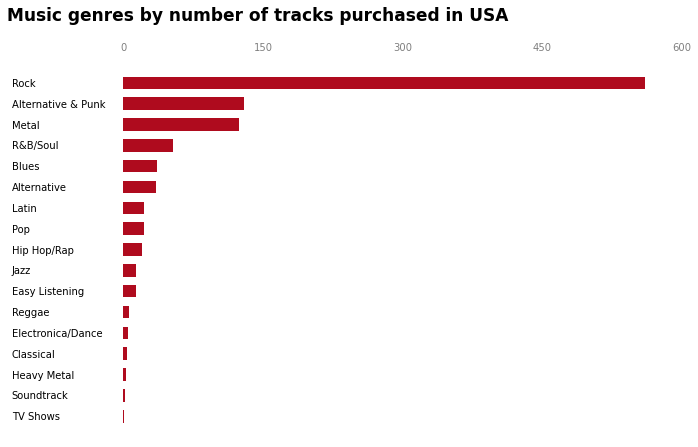

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(result1.sort_values('tracks_purchased',ascending=True)['genre'], ## sorting the DataFrame in reverse order 
        result1.sort_values('tracks_purchased',ascending=True)['tracks_purchased'],
        height=0.6, color='#af0b1e')

for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)            ## remove the entire frame around the bar

ax.set_xticks([0, 150, 300, 450, 600])                ## set xtick values 
ax.set_xticklabels(['0', '150','300', '450', '600'])  ## label xtick values 
ax.xaxis.tick_top()                                   ## move x axis label ticks to the top
ax.tick_params(top=False, left=False)                 ## remove ticks (-) from both top and left
ax.tick_params(axis='x', colors='grey')               ## set the color of x ticks to grey

ax.set_yticklabels([])  ## remove the original yticklabels (tags)
genres = result1.sort_values('tracks_purchased',ascending=True)['genre']   
for i, genre in zip(range(17), genres):                 
    ax.text(x=-120, y=i-0.15, s=genre) ## create new yticklabels by itterating each genre name 

ax.text(x=-125, y=19, s='Music genres by number of tracks purchased in USA', size=17, weight='bold') ## title

plt.show()

## Findings:
#### As the bar illustrates, Rock genre is the most purchased by tracks in USA. Whereas Alternative & Punk and Metal are second and third most purchased music genre in USA respectively. 

## 2) Query that finds the total dollar amount of sales assigned to each sales support agent within the company:

In [6]:
## Since each customer can only be assigned to one sales assistant, I can sum up all the totals by groupping sales rep
q2 = '''
WITH total_by_support_rep AS 
    (
    SELECT c.support_rep_id, 
            SUM(i.total) total
    FROM invoice i
    JOIN customer c ON c.customer_id = i.customer_id
    GROUP BY 1
    )

SELECT 
    e.first_name || " " || e.last_name employee_name,
    tbsp.total
FROM employee e
JOIN total_by_support_rep tbsp ON e.employee_id = tbsp.support_rep_id  

'''

result2 = run(q2)
result2

,employee_name,total
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


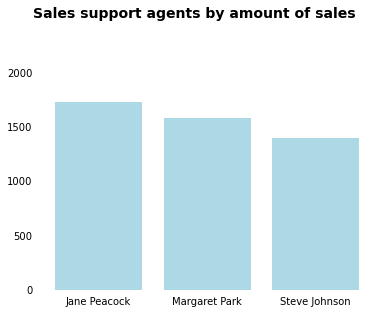

In [7]:
fig, ax = plt.subplots()
ax.bar(result2['employee_name'], result2['total'], color='lightblue')

for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)               ## remove the entire frame around the bar

ax.set_yticks([0, 500, 1000, 1500, 2000])                ## set xtick values 
ax.set_yticklabels(['0', '500','1000', '1500', '2000'])  ## label xtick values 
ax.tick_params(bottom=False, left=False)                 ## remove ticks from labels from both bottom and left

ax.text(x=-0.6, y=2500, s='Sales support agents by amount of sales', size=14, weight='bold') ## title

plt.show()

## Findings: 
#### As you can see above, sales support agents generate almost the same amount of sales. However, Jane Peacock is the leading sales suppor agent who made 1731 dollars worth of sales so far. This information could be useful to find the employee of the month, quarter or year. But since database doesn't have sales made on specific dates, we can only say "so far" instead of specifying a date.

## 3) Query that shows information on purchases for different countries. 
 * Specifically, for each country calculate the total number of customers, total value of sales, average value of sales per customer, average order value.
 * Countries that have one customer are grouped as 'other' in country column

In [8]:
q3 = '''
WITH sub AS (SELECT 
    c.country, 
    COUNT(DISTINCT(c.customer_id)) num_of_customers,
    SUM(i.total) total_sales ,
    SUM(i.total) / COUNT(DISTINCT(c.customer_id)) avg_sales_per_customer,
    SUM(i.total) / COUNT(i.total) avg_value_per_order,
    CASE
        WHEN COUNT(DISTINCT(c.customer_id)) <= 1 THEN "no"
        ELSE "yes"
    END more_than_one_customers 
FROM customer c
JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY 1)

SELECT 
    country,
    num_of_customers,
    total_sales,
    avg_sales_per_customer,
    avg_value_per_order
FROM sub
WHERE more_than_one_customers = 'yes'    

UNION 

SELECT 
    'Other' AS country,
    SUM(num_of_customers) num_of_customers,
    SUM(total_sales) total_sales,
    AVG(avg_sales_per_customer) avg_sales_per_customer,
    AVG(avg_value_per_order) avg_value_per_order
FROM sub
WHERE more_than_one_customers = 'no'

ORDER BY 3 DESC    
'''


result3 = run(q3)
result3

,country,num_of_customers,total_sales,avg_sales_per_customer,avg_value_per_order
0,Other,15,1094.94,72.996000,7.445071
1,USA,13,1040.49,80.037692,7.942672
2,Canada,8,535.59,66.948750,7.047237
3,Brazil,5,427.68,85.536000,7.011148
4,France,5,389.07,77.814000,7.781400
5,Germany,4,334.62,83.655000,8.161463
6,Czech Republic,2,273.24,136.620000,9.108000
7,United Kingdom,3,245.52,81.840000,8.768571
8,Portugal,2,185.13,92.565000,6.383793
9,India,2,183.15,91.575000,8.721429


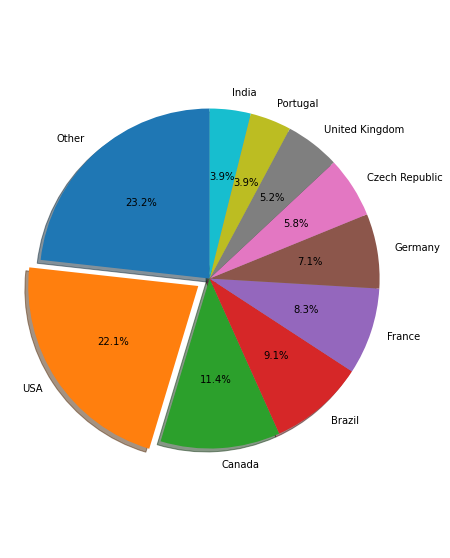

In [9]:
fig, ax = plt.subplots(figsize=(7,10))
ax.pie(result3['total_sales'], labels=result3['country'], shadow=True, startangle=90, autopct='%1.1f%%', 
       explode = (0, 0.08, 0, 0, 0, 0, 0, 0, 0, 0 ))
ax.axis('equal')
plt.show()

## Findings:
#### According to the pie char above, USA seems to be making most of the sales at chinook store. Since other comprises several countries, it doesn't count as the country that makes the most sales.

# THE END